In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Reading and Cleaning Infectious Disease Data

In [2]:
disease = pd.read_csv('inf_dis.csv')

In [3]:
adj_dis = disease[['Year','County','Disease','Sex','Count','Population']]

In [4]:
dis_tot = adj_dis[adj_dis.Sex=='Total']

In [5]:
dis_prep = dis_tot.drop('Sex',axis=1)

In [6]:
dcn = dis_prep[dis_prep.County != 'California']

Original Disease Data Set -- Not Yet Pivoted

In [114]:
dcn.head()

,Year,County,Disease,Count,Population
0,2005,Solano,Amebiasis,0,410570
5,2006,Napa,Amebiasis,2,131920
6,2011,Mariposa,Amebiasis,0,18237
10,2013,Ventura,Amebiasis,7,842639
11,2004,Sierra,Amebiasis,0,3467


Infectious Disease Data: Pivoted and Indexed by County and Year

In [16]:
indicmat = (pd.pivot_table(dcn, index = ['Year', 'County'], 
            columns = 'Disease', 
            values = 'Count')
            .fillna(0)
            .reset_index())

c = indicmat.drop(index=5)
c1 = c.iloc[:,2:]
c3 = c.sort_values(['County','Year'])
c4 = c3.set_index(['County','Year'])
c4.sort_index(inplace=True)
zonemat= c4.drop(['Anthrax', 'Domoic Acid Poisoning'],axis=1)
# disease profile indexed by county, year 
zonemat.head()

Disease       Amebiasis  Anaplasmosis and Ehrlichiosis  Babesiosis  \
County  Year                                                         
Alameda 2001       16.0                            0.0         0.0   
        2002        9.0                            0.0         0.0   
        2003        6.0                            0.0         0.0   
        2004        7.0                            1.0         0.0   
        2005        9.0                            0.0         0.0   

Disease       Botulism, Foodborne  Botulism, Other  Botulism, Wound  \
County  Year                                                          
Alameda 2001                  0.0              0.0              0.0   
        2002                  0.0              0.0              1.0   
        2003                  0.0              0.0              5.0   
        2004                  0.0              0.0              1.0   
        2005                  0.0              0.0              1.0   

Disease       Brucellosis  Campylobacteriosis  Cholera  \
County  Year                                             
Alameda 2001          1.0               252.0      0.0   
        2002          1.0               359.0      0.0   
        2003          0.0               300.0      0.0   
        2004          1.0               310.0      0.0   
        2005          1.0               326.0      0.0   

Disease       Ciguatera Fish Poisoning  ...  Spotted Fever Rickettsiosis  \
County  Year                            ...                                
Alameda 2001                       2.0  ...                          0.0   
        2002                       0.0  ...                          0.0   
        2003                       0.0  ...                          0.0   
        2004                       2.0  ...                          0.0   
        2005                       0.0  ...                          0.0   

Disease       Staphylococcus aureus Infection (cases resulting in death or ICU)  \
County  Year                                                                      
Alameda 2001                                                0.0                   
        2002                                                0.0                   
        2003                                                0.0                   
        2004                                                0.0                   
        2005                                                0.0                   

Disease       Streptococcal Infection (cases in food and dairy workers)  \
County  Year                                                              
Alameda 2001                                                1.0           
        2002                                                0.0           
        2003                                                0.0           
        2004                                                0.0           
        2005                                                0.0           

Disease       Toxic Shock Syndrome (Non-Streptococcal)  Trichinosis  \
County  Year                                                          
Alameda 2001                                       1.0          1.0   
        2002                                       0.0          0.0   
        2003                                       1.0          0.0   
        2004                                       0.0          0.0   
        2005                                       0.0          0.0   

Disease       Tularemia  Typhoid Fever, case  Typhus Fever  \
County  Year                                                 
Alameda 2001        0.0                  9.0           0.0   
        2002        0.0                  6.0           0.0   
        2003        0.0                 11.0           0.0   
        2004        1.0                  9.0           0.0   
        2005        0.0                  8.0           0.0   

Disease       Vibrio Infection

Automated Cleaning and Object Creation for Disease Data in a Dictionary 

In [46]:
import pandas as pd
dy={}
for r in range(1,9):
        dy['pi{0}'.format(r)]= pd.read_csv('pi{0}.csv'.format(r))

for d in dy:
    dy[d].columns = dy[d].iloc[0]
    dy[d].rename(columns={'GeoName':'County'},inplace=True)
    dy[d] = dy[d].loc[2:,:]
    dy[d] = dy[d].dropna()
    dy[d]['Description'] = dy[d]['Description'].str.lstrip()
    dy[d] = dy[d][dy[d]['LineCode']=='10'].drop('Description',axis=1)
    dy[d] = dy[d].drop('LineCode',axis=1)
    dy[d] = dy[d].drop('GeoFips',axis=1)
    q = dy[d]['County'].str.split(',', n=1, expand=True)
    dy[d]['County'] = q[0]
    dy[d]['State'] = q[1]
    dy[d] = dy[d][dy[d]['State']==' CA']
    dy[d] = dy[d].drop('State',axis=1)

Preparing Predictors by Subsetting Data by Year in a Dictionary

In [47]:
lt = {}
for r in range(2002, 2016):
    lt['ml{0}'.format(r)] = zonemat.loc[(slice(None),r),:].reset_index().drop(['County','Year'],axis=1)['Amebiasis']
lt['ml2002'][0:5]

0    9.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Amebiasis, dtype: float64

In [48]:
dt = {}
i = 2
for r in range(2002,2015):
    dt['X{0}'.format(i)] = lt['ml{0}'.format(r)]
    i += 1
Y = lt['ml2015']
#X1 = ml01.Amebiasis
dt['X2'][0:5]

0    9.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Amebiasis, dtype: float64

Running Generalized Linear Model via Negative Binomial

In [85]:
import statsmodels.api as sm
from statsmodels.formula.api import glm

formula = 'Y ~ X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11 + X12 + X13 + X14'
nb = glm(formula = formula, data = dt, family = sm.families.NegativeBinomial()).fit()

print(nb.summary())

pms = np.exp(nb.params)
# X1, missing county observation

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                   58
Model:                            GLM   Df Residuals:                       44
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -101.17
Date:                Tue, 23 Jul 2019   Deviance:                       47.555
Time:                        20:33:30   Pearson chi2:                     45.7
No. Iterations:                   100   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4035      0.251     -1.606      0.108      -0.896       0.089
X2            -0.0348      0.089     -0.392      0.6

In [51]:
predarr = nb.predict()
predarr
# 58 entries for each county 

array([26.51848612,  0.66799106,  0.66799106,  0.98785768,  0.72319842,
        0.66799106,  3.94932678,  0.66799106,  0.53293509,  0.77475153,
        0.64118586,  0.3391346 ,  0.49087725,  0.87806102,  1.17879317,
        1.00593879,  0.66799106,  0.75314083, 97.04338331,  1.15157857,
        1.7480911 ,  0.69504682,  4.56606788,  0.73657731,  0.66799106,
        0.66799106,  3.33399395,  1.12063294,  0.72642923, 11.83785196,
        0.52467559,  0.66799106,  9.26242366,  3.87482967,  1.6419186 ,
        1.35771074, 39.52419065, 44.31511111,  0.34114733,  0.85367308,
        6.29951832,  0.22858715, 12.31183991,  1.479091  ,  0.77379016,
        0.66799106,  0.61486784,  2.51810602,  1.9608592 ,  1.41453742,
        0.65164728,  0.60707366,  0.66799106,  0.19857096,  0.66799106,
       10.94334668,  0.7055027 ,  0.8876992 ])

Prep for Merge, Cleaning Economic Factors Data Sets: Personal Income and Unemployment Rate 

In [115]:
import pandas as pd
dy={}
for r in range(1,9):
        dy['pi{0}'.format(r)]= pd.read_csv('pi{0}.csv'.format(r))
#dy['pi8'].head()

In [116]:
for d in dy:
    dy[d].columns = dy[d].iloc[0]
    dy[d].rename(columns={'GeoName':'County'},inplace=True)
#'Unnamed: 4':dy[d].columns[4], 
#'Unnamed: 5':dy[d].columns[5]}, inplace=True)
    dy[d] = dy[d].loc[2:,:]
    dy[d] = dy[d].dropna()
    dy[d]['Description'] = dy[d]['Description'].str.lstrip()
    dy[d] = dy[d][dy[d]['LineCode']=='10'].drop('Description',axis=1)
    dy[d] = dy[d].drop('LineCode',axis=1)
    dy[d] = dy[d].drop('GeoFips',axis=1)
    q = dy[d]['County'].str.split(',', n=1, expand=True)
    dy[d]['County'] = q[0]
    dy[d]['State'] = q[1]
    dy[d] = dy[d][dy[d]['State']==' CA']
    dy[d] = dy[d].drop('State',axis=1)
#dy['pi2'].head()

In [117]:
from functools import partial, reduce
part = partial(pd.merge, how='left', on=['County'])                                                              
personal_income = reduce(part, dy.values()) 
personal_income.head()

,County,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Alameda,57937010,57428282,58602235,60674155,62902099,67751723,70450120,72298889,69426673,72821639,78521460,83005645,87659801,95056828,104464523,111354955
1,Alpine,41395,42630,44357,42594,42330,42920,45802,46336,47295,49662,62358,66728,67205,73553,76225,78759
2,Amador,956884,1010686,1063008,1131812,1155794,1230694,1289844,1309924,1272579,1301768,1333900,1352484,1381381,1461506,1549948,1600953
3,Butte,5167986,5315013,5576133,5950239,6170006,6553340,6859094,7034312,7047335,7307770,7574070,7784914,8133014,8492494,9152079,9498336
4,Calaveras,1167747,1228271,1319394,1397555,1458892,1561842,1648560,1685096,1645864,1670057,1724819,1705017,1729741,1846586,1983198,2064459


In [118]:
pers_inc = pd.melt(personal_income,id_vars='County', var_name='Year', 
                value_name='Personal_Income')
pers_inc.head()

,County,Year,Personal_Income
0,Alameda,2001,57937010
1,Alpine,2001,41395
2,Amador,2001,956884
3,Butte,2001,5167986
4,Calaveras,2001,1167747


In [119]:
unemployment_rate = pd.read_excel('unemployment.xls',
                      sheet_name='Unemployment Med HH Inc',
                      skiprows=range(0,7))

In [120]:
unemployment_rate.rename(columns={"Area_name":"County"}, inplace=True)

In [121]:
unemployment_rate['County'] = unemployment_rate['County'].apply(lambda x:x.split(',')[0])

In [122]:
unemployment_rate['County'] = unemployment_rate['County'].apply(lambda x:x.split('County')[0])

In [123]:
unemployment_rate['County'] = unemployment_rate['County'].apply(lambda x:x.split('/')[0])
unemp_l = unemployment_rate.loc[2:,:]

In [124]:
unemp2 = unemp_l.drop(['FIPStxt','Rural_urban_continuum_code_2013',
                       'Urban_influence_code_2013','Metro_2013',
                       'Civilian_labor_force_2007','Employed_2007',
                       'Unemployed_2007','Civilian_labor_force_2008',
                       'Employed_2008','Unemployed_2008',
                       'Civilian_labor_force_2009','Employed_2009',
                       'Unemployed_2009','Civilian_labor_force_2010',
                       'Employed_2010','Unemployed_2010',
                       'Civilian_labor_force_2010','Employed_2010',
                       'Unemployed_2010','Civilian_labor_force_2011',
                       'Employed_2011','Unemployed_2011',
                       'Civilian_labor_force_2012','Employed_2012',
                       'Unemployed_2012','Civilian_labor_force_2013',
                       'Employed_2013','Unemployed_2013',
                       'Civilian_labor_force_2014','Employed_2014',
                       'Unemployed_2014','Civilian_labor_force_2015',
                       'Employed_2015','Unemployed_2015',
                       'Civilian_labor_force_2016','Employed_2016',
                       'Unemployed_2016','Civilian_labor_force_2017',
                       'Employed_2017','Unemployed_2017'],axis=1)

In [125]:
unemp2.rename(columns={"State":"Postal"},inplace=True)

In [126]:
unemp2.drop(['Median_Household_Income_2017','Med_HH_Income_Percent_of_State_Total_2017'],axis=1).head()

,Postal,County,Unemployment_rate_2007,Unemployment_rate_2008,Unemployment_rate_2009,Unemployment_rate_2010,Unemployment_rate_2011,Unemployment_rate_2012,Unemployment_rate_2013,Unemployment_rate_2014,Unemployment_rate_2015,Unemployment_rate_2016,Unemployment_rate_2017
2,AL,Autauga,3.3,5.1,9.7,8.9,8.4,6.9,6.2,5.8,5.2,5.1,3.9
3,AL,Baldwin,3.1,4.6,9.8,10.0,9.0,7.5,6.6,6.1,5.5,5.4,4.0
4,AL,Barbour,6.3,8.8,14.3,12.3,11.5,11.5,10.2,10.5,8.9,8.4,5.9
5,AL,Bibb,4.1,5.8,13.3,11.4,10.5,8.5,7.9,7.2,6.6,6.5,4.4
6,AL,Blount,3.2,4.7,10.0,9.8,8.7,6.9,6.3,6.1,5.4,5.4,4.0


In [127]:
unemp_california = unemp2[unemp2['Postal'] == 'CA'].iloc[1:,:]

In [128]:
unempca = pd.melt(unemp_california,id_vars=['County','Postal'],var_name='Year',value_name='UnemploymentRate')

In [129]:
unempca['Year'] = unempca['Year'].str.strip().str[-4:]

In [130]:
unempca['County'] = unempca['County'].str.strip(' ')

In [131]:
unempca['Year'] = unempca['Year'].astype(int)

In [132]:
unempca['County'] = unempca['County'].str.strip(' ')

In [133]:
unempca[unempca['Postal']=='CA'].head()

,County,Postal,Year,UnemploymentRate
0,Alameda,CA,2007,4.7
1,Alpine,CA,2007,7.9
2,Amador,CA,2007,5.8
3,Butte,CA,2007,6.7
4,Calaveras,CA,2007,6.4


In [134]:
pers_inc['Year'] = pers_inc['Year'].astype(int)

Merging Economic Factors: Personal Income and Unemployment Rate

In [135]:
personal_income_unemployment_rate = pd.merge(pincM,unempca,how='left',on=['County','Year']).dropna()

In [136]:
save = pers_inc.iloc[4,:].values
save

array(['Calaveras', 2001, '1167747'], dtype=object)

In [137]:
personal_income_unemployment_rate = personal_income_unemployment_rate.drop('Postal',axis=1)

Merging Original Disease Data with Economic Factors Data

In [191]:
# dcn has no clustering but may have null cluster column 
dis_econ = pd.merge(dcn,personal_income_unemployment_rate, how='left', on=['County','Year']).drop_duplicates().dropna()
dis_econ = dis_econ[dis_econ.Disease != 'Anthrax']
dis_econ = dis_econ[dis_econ.Disease != 'Domoic Acid Poisoning']
dis_econ.loc[:,'Personal_Income'] = dis_econ.loc[:,'Personal_Income'].astype(int)
econ = dis_econ.drop(['Disease','Count','Population'],axis=1)
econ.head()

,Year,County,Personal_Income,UnemploymentRate
2,2011,Mariposa,676485,13.2
3,2013,Ventura,42313336,7.9
5,2009,Madera,3863788,13.4
6,2008,Santa Barbara,19022250,5.5
9,2009,Tehama,1756324,13.6


In [192]:
dis_econ = dis_econ.sort_values(['Year','County']).drop_duplicates()
dis_econ.head()

,Year,County,Disease,Count,Population,Personal_Income,UnemploymentRate
688,2007,Alameda,Amebiasis,9,1476401,70450120,4.7
1507,2007,Alameda,Anaplasmosis and Ehrlichiosis,0,1476401,70450120,4.7
2860,2007,Alameda,Babesiosis,0,1476401,70450120,4.7
4332,2007,Alameda,"Botulism, Foodborne",0,1476401,70450120,4.7
4623,2007,Alameda,"Botulism, Other",0,1476401,70450120,4.7


In [193]:
dis_econ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26100 entries, 688 to 42819
Data columns (total 7 columns):
Year                26100 non-null int64
County              26100 non-null object
Disease             26100 non-null object
Count               26100 non-null int64
Population          26100 non-null int64
Personal_Income     26100 non-null int32
UnemploymentRate    26100 non-null float64
dtypes: float64(1), int32(1), int64(3), object(2)
memory usage: 1.5+ MB


Merge Pivoted Disease and Economic Factors Data, All California Counties, Not Yet Indexed by Year and County

In [196]:
disease_profile = pd.merge(zonemat,dis_econ,how='left',on=['County','Year']).drop(['Disease',
                           'Count'],axis=1).drop_duplicates().dropna()
disease_profile.head(9)

,County,Year,Amebiasis,Anaplasmosis and Ehrlichiosis,Babesiosis,"Botulism, Foodborne","Botulism, Other","Botulism, Wound",Brucellosis,Campylobacteriosis,...,Toxic Shock Syndrome (Non-Streptococcal),Trichinosis,Tularemia,"Typhoid Fever, case",Typhus Fever,Vibrio Infection (non-Cholera),Yersiniosis,Population,Personal_Income,UnemploymentRate
6,Alameda,2007,9.0,0.0,0.0,0.0,0.0,2.0,3.0,363.0,...,0.0,0.0,1.0,8.0,0.0,2.0,9.0,1476401.0,70450120.0,4.7
54,Alameda,2008,9.0,0.0,1.0,1.0,0.0,1.0,0.0,328.0,...,0.0,0.0,2.0,12.0,0.0,7.0,2.0,1491781.0,72298889.0,6.2
103,Alameda,2009,15.0,0.0,1.0,0.0,0.0,6.0,1.0,348.0,...,2.0,0.0,0.0,9.0,0.0,4.0,5.0,1503827.0,69426673.0,10.3
152,Alameda,2010,24.0,0.0,0.0,0.0,0.0,3.0,0.0,357.0,...,0.0,0.0,0.0,7.0,0.0,8.0,4.0,1515338.0,72821639.0,10.9
201,Alameda,2011,21.0,0.0,1.0,0.0,0.0,1.0,1.0,360.0,...,0.0,0.0,1.0,7.0,0.0,2.0,5.0,1531942.0,78521460.0,10.1
252,Alameda,2012,27.0,0.0,0.0,0.0,0.0,0.0,0.0,417.0,...,0.0,0.0,0.0,8.0,0.0,8.0,3.0,1554446.0,83005645.0,8.7
303,Alameda,2013,12.0,0.0,0.0,0.0,0.0,0.0,0.0,409.0,...,0.0,0.0,0.0,8.0,0.0,13.0,8.0,1575797.0,87659801.0,7.2
354,Alameda,2014,12.0,0.0,0.0,0.0,0.0,2.0,0.0,392.0,...,0.0,0.0,0.0,11.0,0.0,16.0,6.0,1599685.0,95056828.0,5.8
405,Alameda,2015,65.0,0.0,2.0,0.0,0.0,1.0,2.0,445.0,...,3.0,0.0,0.0,8.0,0.0,5.0,7.0,1619679.0,104464523.0,4.7


Disease Profile Indexed by County and Year

In [197]:
dis_pro = disease_profile.set_index(['County','Year'])
dis_pro.head(9)

Amebiasis  Anaplasmosis and Ehrlichiosis  Babesiosis  \
County  Year                                                         
Alameda 2007        9.0                            0.0         0.0   
        2008        9.0                            0.0         1.0   
        2009       15.0                            0.0         1.0   
        2010       24.0                            0.0         0.0   
        2011       21.0                            0.0         1.0   
        2012       27.0                            0.0         0.0   
        2013       12.0                            0.0         0.0   
        2014       12.0                            0.0         0.0   
        2015       65.0                            0.0         2.0   

              Botulism, Foodborne  Botulism, Other  Botulism, Wound  \
County  Year                                                          
Alameda 2007                  0.0              0.0              2.0   
        2008                  1.0              0.0              1.0   
        2009                  0.0              0.0              6.0   
        2010                  0.0              0.0              3.0   
        2011                  0.0              0.0              1.0   
        2012                  0.0              0.0              0.0   
        2013                  0.0              0.0              0.0   
        2014                  0.0              0.0              2.0   
        2015                  0.0              0.0              1.0   

              Brucellosis  Campylobacteriosis  Cholera  \
County  Year                                             
Alameda 2007          3.0               363.0      1.0   
        2008          0.0               328.0      0.0   
        2009          1.0               348.0      0.0   
        2010          0.0               357.0      0.0   
        2011          1.0               360.0      0.0   
        2012          0.0               417.0      0.0   
        2013          0.0               409.0      0.0   
        2014          0.0               392.0      0.0   
        2015          2.0               445.0      0.0   

              Ciguatera Fish Poisoning  ...  \
County  Year                            ...   
Alameda 2007                       0.0  ...   
        2008                       0.0  ...   
        2009                       1.0  ...   
        2010                       0.0  ...   
        2011                       0.0  ...   
        2012                       0.0  ...   
        2013                       0.0  ...   
        2014                       1.0  ...   
        2015                       0.0  ...   

              Toxic Shock Syndrome (Non-Streptococcal)  Trichinosis  \
County  Year                                                          
Alameda 2007                                       0.0          0.0   
        2008                                       0.0          0.0   
        2009                                       2.0          0.0   
        2010                                       0.0          0.0   
        2011                                       0.0          0.0   
        2012                                       0.0          0.0   
        2013                                       0.0          0.0   
        2014                                       0.0          0.0   
        2015                                       3.0          0.0   

              Tularemia  Typhoid Fever, case  Typhus Fever  \
County  Year                                                 
Alameda 2007        1.0                  8.0           0.0   
        2008        2.0                 12.0           0.0   
        2009        0.0                  9.0           0.0   
        2010        0.0                  7.0           0.0   
        2011        1.0                  7.0           0.0   
        2012        0.0                  8.0           0.0   
        2013        0.0   

Combined Data Set of Economic Factors and Diseases Subset by 5 Counties (Alameda,San Francisco,Los Angeles,San Joaquin,Stanislaus) in 5 DataFrame Objects

In [198]:
dis_pro_Alameda = dis_pro.loc[('Alameda',slice(None)),:]
dis_pro_SF= dis_pro.loc[('San Francisco',slice(None)),:]
dis_pro_LA = dis_pro.loc[('Los Angeles',slice(None)),:]
dis_pro_Stanislaus = dis_pro.loc[('Stanislaus',slice(None)),:]
dis_pro_SanJoaquin = dis_pro.loc[('San Joaquin',slice(None)),:]
dis_pro_Alameda = dis_pro_Alameda.reset_index().drop('County',axis=1)
dis_pro_alam = dis_pro_Alameda.set_index('Year')
dis_pro_alam

,Amebiasis,Anaplasmosis and Ehrlichiosis,Babesiosis,"Botulism, Foodborne","Botulism, Other","Botulism, Wound",Brucellosis,Campylobacteriosis,Cholera,Ciguatera Fish Poisoning,...,Toxic Shock Syndrome (Non-Streptococcal),Trichinosis,Tularemia,"Typhoid Fever, case",Typhus Fever,Vibrio Infection (non-Cholera),Yersiniosis,Population,Personal_Income,UnemploymentRate
Year,,,,,,,,,,,,,,,,,,,,,
2007,9.0,0.0,0.0,0.0,0.0,2.0,3.0,363.0,1.0,0.0,...,0.0,0.0,1.0,8.0,0.0,2.0,9.0,1476401.0,70450120.0,4.7
2008,9.0,0.0,1.0,1.0,0.0,1.0,0.0,328.0,0.0,0.0,...,0.0,0.0,2.0,12.0,0.0,7.0,2.0,1491781.0,72298889.0,6.2
2009,15.0,0.0,1.0,0.0,0.0,6.0,1.0,348.0,0.0,1.0,...,2.0,0.0,0.0,9.0,0.0,4.0,5.0,1503827.0,69426673.0,10.3
2010,24.0,0.0,0.0,0.0,0.0,3.0,0.0,357.0,0.0,0.0,...,0.0,0.0,0.0,7.0,0.0,8.0,4.0,1515338.0,72821639.0,10.9
2011,21.0,0.0,1.0,0.0,0.0,1.0,1.0,360.0,0.0,0.0,...,0.0,0.0,1.0,7.0,0.0,2.0,5.0,1531942.0,78521460.0,10.1
2012,27.0,0.0,0.0,0.0,0.0,0.0,0.0,417.0,0.0,0.0,...,0.0,0.0,0.0,8.0,0.0,8.0,3.0,1554446.0,83005645.0,8.7
2013,12.0,0.0,0.0,0.0,0.0,0.0,0.0,409.0,0.0,0.0,...,0.0,0.0,0.0,8.0,0.0,13.0,8.0,1575797.0,87659801.0,7.2
2014,12.0,0.0,0.0,0.0,0.0,2.0,0.0,392.0,0.0,1.0,...,0.0,0.0,0.0,11.0,0.0,16.0,6.0,1599685.0,95056828.0,5.8
2015,65.0,0.0,2.0,0.0,0.0,1.0,2.0,445.0,0.0,0.0,...,3.0,0.0,0.0,8.0,0.0,5.0,7.0,1619679.0,104464523.0,4.7


Univariate ARIMA Model of One Disease Amebiasis

C:\Users\aufst\OneDrive\Music\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\aufst\OneDrive\Music\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Amebiasis   No. Observations:                    8
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -34.748
Method:                       css-mle   S.D. of innovations             18.583
Date:                Tue, 23 Jul 2019   AIC                             75.495
Time:                        21:41:13   BIC                             75.734
Sample:                             1   HQIC                            73.888
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.1902      6.141      1.008      0.352      -5.846      18.227
ar.L1.D.Amebiasis    -0.1898      0.653     -0.291      0.781      -1.470       1.090
                        

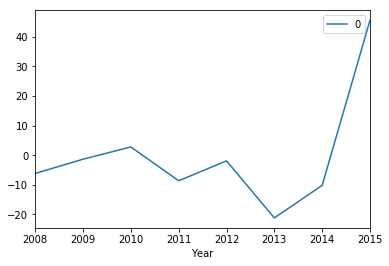

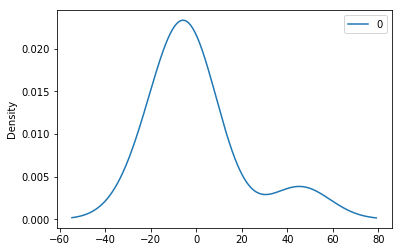

               0
count   8.000000
mean   -0.146825
std    19.870218
min   -21.226257
25%    -9.045536
50%    -4.062133
75%    -0.330176
max    45.635184


In [199]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(dis_pro_alam.Amebiasis, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [200]:
import itertools
import xgboost as xgb

# importing useful functions
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_predict, KFold, train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, roc_curve
from sklearn.ensemble import VotingClassifier

In [202]:
from statsmodels.formula.api import ols

formula = 'Y ~ X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11 + X12 + X13 + X14'
ls = ols(formula = formula, data = dt).fit()
print(ls.summary())
# f stat tells us that there is more variation within each year of counts(between counties) than between years
# since all counties can be found in each year, the variation is probably coming from county
# variation 

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     49.55
Date:                Tue, 23 Jul 2019   Prob (F-statistic):           6.68e-22
Time:                        21:54:46   Log-Likelihood:                -155.52
No. Observations:                  58   AIC:                             339.0
Df Residuals:                      44   BIC:                             367.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9102      0.642      1.418      0.1

In [206]:
dt1 = {}
for r in range(2007, 2016):
    dt1['m{0}'.format(r)] = dis_pro.loc[(slice(None),r),:].reset_index().drop(['County','Year'],axis=1)['UnemploymentRate']
dt1['m2007'][0:5]

0    4.7
1    7.9
2    5.8
3    6.7
4    6.4
Name: UnemploymentRate, dtype: float64

In [207]:
dt2 = {}
i = 7
for r in range(2007,2015):
    dt2['X{0}'.format(i)] = dt1['m{0}'.format(r)]
    i += 1
Y = dt1['m2015']
dt2['X7'][0:5]

0    4.7
1    7.9
2    5.8
3    6.7
4    6.4
Name: UnemploymentRate, dtype: float64

Running OLS on Unemployment Rate using **dis_pro** DataFrame 2007-2014, Targeting 2015

In [208]:
formula = 'Y ~ X7 + X8 + X9 + X10 + X11 + X12 + X13 + X14'
ls = ols(formula = formula, data = dt2).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     681.0
Date:                Tue, 23 Jul 2019   Prob (F-statistic):           1.81e-47
Time:                        22:08:01   Log-Likelihood:                -12.941
No. Observations:                  58   AIC:                             43.88
Df Residuals:                      49   BIC:                             62.43
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2333      0.296     -0.789      0.4

Transposing Alameda Data Subset from *dis_pro* for Regression Models

In [216]:
transpose_alameda = dis_pro_alam.transpose()
alamX = transpose_alameda.drop(2015,axis=1)
alamY = transpose_alameda[2015]
alamX.head()

Year,2007,2008,2009,2010,2011,2012,2013,2014
Amebiasis,9.0,9.0,15.0,24.0,21.0,27.0,12.0,12.0
Anaplasmosis and Ehrlichiosis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Babesiosis,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
"Botulism, Foodborne",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"Botulism, Other",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [217]:
X_train, X_test, y_train, y_test = train_test_split(alamX, alamY, 
                                                    train_size = 0.75, test_size = 0.25, 
                                                    random_state = 42)

In [218]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9897978341215024

In [219]:
import numpy as np
from sklearn import linear_model
from sklearn import svm

classifiers = [
#    linear_model.BayesianRidge(),
    linear_model.LassoLars(),
    linear_model.TheilSenRegressor(),
    linear_model.LinearRegression()]

In [220]:
for item in classifiers:
    print(item)
    clf = item
    clf.fit(X_train, y_train)
    print(clf.predict(X_test),'Score: ',clf.score(X_test, y_test) ,'\n')

LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False)
[2.18156711e+02 2.37626043e+01 7.56309546e+00 1.66753192e+01
 7.56309546e+00 9.58803407e+00 2.98374202e+01 9.62421281e+07
 7.56309546e+00 7.56309546e+00 7.56309546e+00 7.56309546e+00
 7.56309546e+00 7.56309546e+00] Score:  0.9933281862393104 

TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=None, n_subsamples=None,
         random_state=None, tol=0.001, verbose=False)
[ 2.25340892e+02  1.17437508e+01  6.42246559e-03  8.95738723e+00
 -6.23247326e-01 -2.65077378e-01  3.04209562e+01  1.14099092e+08
 -2.86147073e-02  6.42246559e-03  6.42246559e-03 -2.19900680e-01
  2.76872230e+00 -2.20219456e-02] Score:  0.9908396542858128 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[ 2.99215997e+02 -3.40982720e+00  4.43